In [1]:
!pip install Twython

In [2]:
from twython import Twython, TwythonError

In [3]:
!echo "itJsoxgE5DCY2JS19W4mgvvE1" >> keys.txt
!echo "dK1C2BgUsAYJK66sRD8tSxBblZsaR9ycDQjElmdMkwnKjshRiq" >> keys.txt

In [4]:
!ls
!cat keys.txt

keys.txt  sample_data
itJsoxgE5DCY2JS19W4mgvvE1
dK1C2BgUsAYJK66sRD8tSxBblZsaR9ycDQjElmdMkwnKjshRiq


In [5]:
# open the keys file
my_file = open("keys.txt", "r")
# read the raw data
content = my_file.read()
# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split()
# close the file
my_file.close()

In [6]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=CFRMlgAAAAABZIPPAAABfw8nvKQ


In [7]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '3289144'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.


In [9]:
twitter.get_application_rate_limit_status()['resources']['search']['/search/tweets']['remaining']

180

In [10]:
def get_remaining():
  return twitter.get_application_rate_limit_status()['resources']['search']['/search/tweets']['remaining']

In [ ]:
import itertools
from time import sleep

SEARCH_QUOTE = 'Ukraine War Russia'
NUM_TWEETS_TO_FETCH = 5000
CURSOR_COUNT = 100
FIVETEEN_MINUTES = 900

fetched_tweets = []
dates = ['2022-02-11',
         '2022-02-12',
         '2022-02-13',
         '2022-02-14',
         '2022-02-15',
         '2022-02-16',
         '2022-02-17']

for date in range(len(dates)):
    cursor = twitter.cursor(twitter.search, q=SEARCH_QUOTE, count=CURSOR_COUNT, result_type='mixed', until=dates[date])
    remaining = get_remaining()
    while remaining <= CURSOR_COUNT:
      sleep(FIVETEEN_MINUTES)
      remaining = get_remaining()
    search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
    fetched_tweets.append(search_tweets)

print(fetched_tweets)

In [19]:
from datetime import datetime
import pandas as pd

dict_ = {'user': [],
         'date': [],
         'text': [],
         'location': [],
         'retweeter_usr':[]}

for tweets in fetched_tweets:
    retweets = [tweet for tweet in tweets if 'retweeted_status' in tweet and tweet['user']['location']]
    for tweet in retweets:
        dict_['user'].append(tweet['user']['screen_name'])
        dict_['date'].append(tweet['created_at'])
        dict_['text'].append(tweet['text'])
        dict_['location'].append(tweet['user']['location'])
        retweeted_status = tweet['retweeted_status']
        dict_['retweeter_usr'] = retweeted_status['user']['screen_name']
# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)
df.drop_duplicates(inplace=True)
df.to_csv('data.csv', sep=';', index=False)


In [20]:
df.head()

,user,date,text,location,retweeter_usr
0,Red_octubre,Thu Feb 10 23:59:58 +0000 2022,RT @JenniferJJacobs: “American citizens should...,Murmansk,KatyaYushchenko
1,janrobinjackson,Thu Feb 10 23:59:56 +0000 2022,RT @JCBua: As Biden Might Say “No Joke” Lester...,"Nashville, TN",KatyaYushchenko
2,HateTheMachine,Thu Feb 10 23:59:56 +0000 2022,RT @STWuk: We reject Keir Starmer's attack in ...,The Universe,KatyaYushchenko
3,kwaku_j,Thu Feb 10 23:59:40 +0000 2022,RT @BreakingNews: When asked what scenario cou...,ghana,KatyaYushchenko
4,Paul4Labour,Thu Feb 10 23:59:35 +0000 2022,RT @STWuk: We reject Keir Starmer's attack in ...,"City of London, London",KatyaYushchenko


In [21]:
df['retweeter_usr'].unique()

array(['KatyaYushchenko'], dtype=object)

In [22]:
import networkx as nx

D = nx.DiGraph()

for index, row in df.iterrows():
    retweeted_sn = (row['user'], row['location'])
    retweeter_sn = (row['retweeter_usr'], row['location'])
    # Edge direction: retweeted_sn -> retweeter_sn
    if D.has_edge(retweeter_sn, retweeted_sn):
        D.edges[retweeter_sn, retweeted_sn]['weight'] += 1
    else:
        D.add_edge(retweeter_sn, retweeted_sn, weight=1)

In [23]:
max(D.nodes, key=D.out_degree)

('KatyaYushchenko', 'United States')

In [24]:
from operator import itemgetter

sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:10]

[(('KatyaYushchenko', 'United States'), 75),
 (('KatyaYushchenko', 'London'), 46),
 (('KatyaYushchenko', 'Washington, DC'), 32),
 (('KatyaYushchenko', 'USA'), 31),
 (('KatyaYushchenko', 'London, England'), 31),
 (('KatyaYushchenko', 'Nigeria'), 29),
 (('KatyaYushchenko', 'India'), 24),
 (('KatyaYushchenko', 'Lagos, Nigeria'), 24),
 (('KatyaYushchenko', 'United Kingdom'), 23),
 (('KatyaYushchenko', 'Florida, USA'), 21)]

In [25]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[(('KatyaYushchenko', 'United States'), 86),
 (('KatyaYushchenko', 'London'), 54),
 (('KatyaYushchenko', 'USA'), 36),
 (('KatyaYushchenko', 'Nigeria'), 34),
 (('KatyaYushchenko', 'Washington, DC'), 34)]

In [26]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[(('JukkaPSeppl', 'Western Finland'), 5),
 (('trustingmyvibes', 'Tennessee, USA'), 5),
 (('StillServingDSS', 'South Asia, Europe, Mideast'), 5),
 (('ibalamuhammad', 'Nigeria'), 4),
 (('Fio_edwards', 'London'), 4)]

In [27]:
nx.is_weakly_connected(D)

False

In [28]:
nx.number_weakly_connected_components(D)

2216

In [29]:
nx.write_graphml(D,'russia_war_ukraine.graphml')

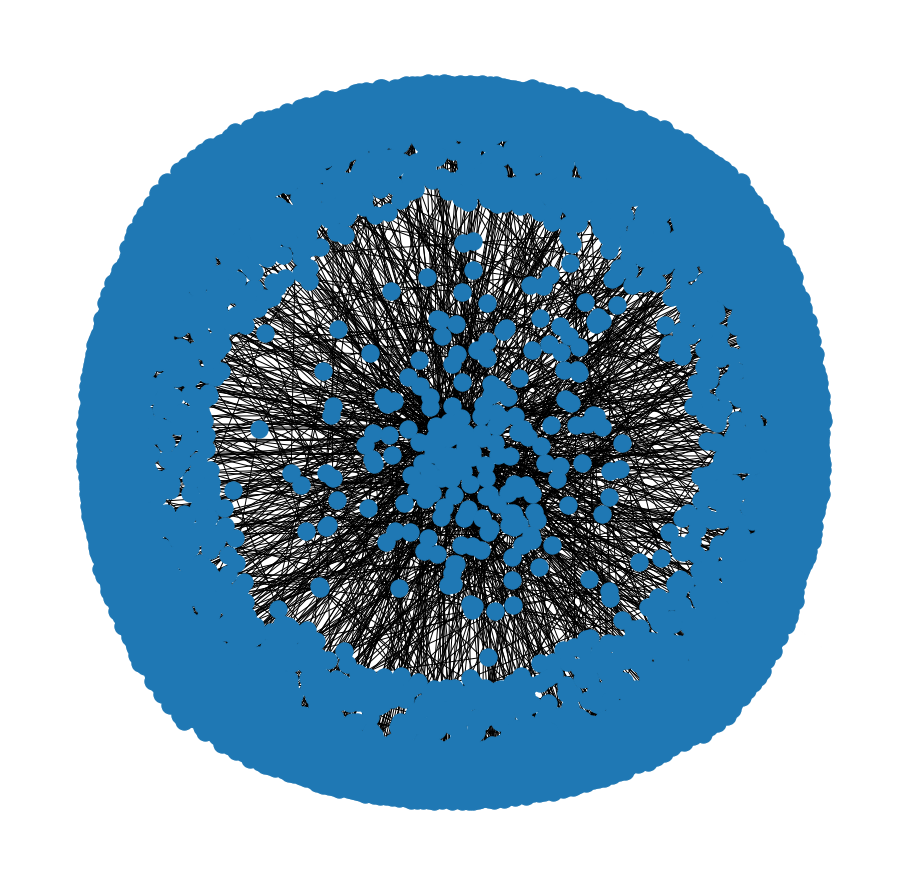

In [30]:
import matplotlib.pyplot as plt

FIGSIZE = (16, 16)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
nx.draw_networkx(D, ax=ax, with_labels=False)
plt.axis("off")
plt.show()